# Faster R-CNN with FPN training



In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
from tqdm.notebook import tqdm
import torch

sys.path.insert(0, os.path.abspath('../../src/obj_det'))

Let's have a look at the dataset and how it is layed down.

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [2]:
from PIL import Image
import os.path as osp

data_root_dir = '../../data/MOT17Det'
output_dir = "../../output/faster_rcnn_fpn/faster_rcnn_fpn_training_mot_17_split_09"

if not osp.exists(output_dir):
    os.makedirs(output_dir)

# Image.open(osp.join(data_root_dir, 'train/MOT17-02/img1/000001.jpg'))

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [3]:
from mot_data import MOTObjDetect

525


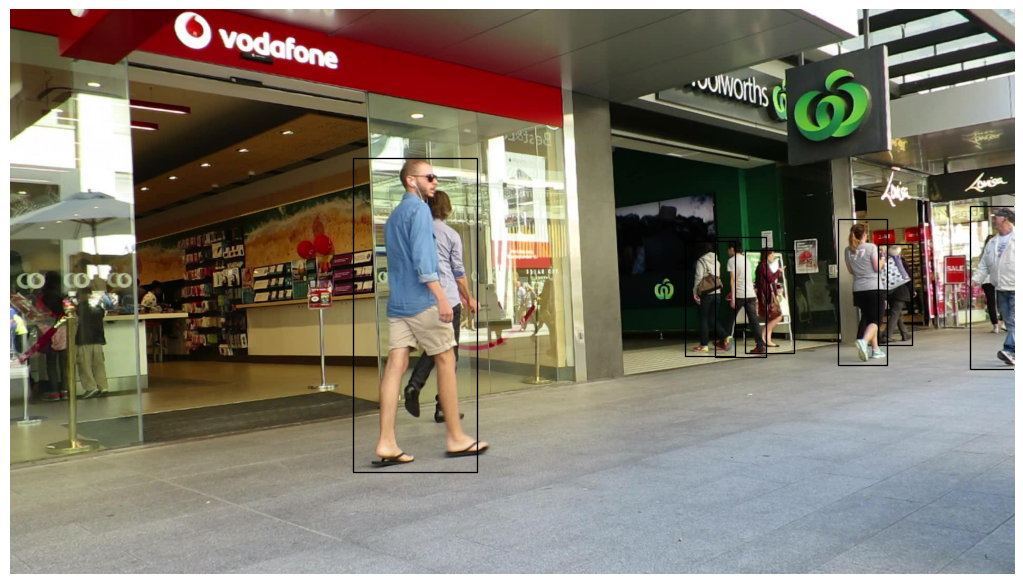

In [4]:
import matplotlib.pyplot as plt
import transforms as T

def plot(img, boxes):
  fig, ax = plt.subplots(1, dpi=96)

  img = img.mul(255).permute(1, 2, 0).byte().numpy()
  width, height, _ = img.shape
    
  ax.imshow(img, cmap='gray')
  fig.set_size_inches(width / 80, height / 80)

  for box in boxes:
      rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=1.0)
      ax.add_patch(rect)

  plt.axis('off')
  plt.show()

dataset = MOTObjDetect(osp.join(data_root_dir, 'train'), split_seqs=['MOT17-09'])
print(len(dataset))
img, target = dataset[-5]
img, target = T.ToTensor()(img, target)
plot(img, target['boxes'])

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [5]:
dataset.num_classes

2

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.nms_thresh = 0.3
    
    return model

DATASETS

In [6]:
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
train_split_seqs = test_split_seqs = None

# train_split_seqs = ['MOT17-02', 'MOT17-04', 'MOT17-05', 'MOT17-09', 'MOT17-10', 'MOT17-11', 'MOT17-13']

train_split_seqs = ['MOT17-05', 'MOT17-09', 'MOT17-11']
test_split_seqs = ['MOT17-09']
for seq in test_split_seqs:
    train_split_seqs.remove(seq)

# use our dataset and defined transformations
dataset = MOTObjDetect(
    osp.join(data_root_dir, 'train'),
    get_transform(train=True),
    split_seqs=train_split_seqs)
dataset_no_random = MOTObjDetect(
    osp.join(data_root_dir, 'train'),
    get_transform(train=False),
    split_seqs=train_split_seqs)
# dataset_test = MOTObjDetect(
#     osp.join(data_root_dir, 'test'),
#     get_transform(train=False))
dataset_test = MOTObjDetect(
    osp.join(data_root_dir, 'train'),
    get_transform(train=False),
    split_seqs=test_split_seqs)

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    # dataset, batch_size=2, shuffle=True, num_workers=4,
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)
data_loader_no_random = torch.utils.data.DataLoader(
    # dataset_no_random, batch_size=2, shuffle=False, num_workers=4,
    dataset_no_random, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    # dataset_test, batch_size=2, shuffle=False, num_workers=4,
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

INIT MODEL AND OPTIM

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_detection_model(dataset.num_classes)
# move model to the right device
model.to(device)

# model_state_dict = torch.load(osp.join(output_dir, 'model_epoch_30.model'))
# model.load_state_dict(model_state_dict)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

256
7


TRAINING

In [9]:
def evaluate_and_write_result_files(model, data_loader):
  print(f'EVAL {data_loader.dataset}')
  model.eval()
  results = {}
  for imgs, targets in tqdm(data_loader):
    imgs = [img.to(device) for img in imgs]

    with torch.no_grad():
        preds = model(imgs)[0]
    
    for pred, target in zip(preds, targets):
        results[target['image_id'].item()] = {'boxes': pred['boxes'].cpu(),
                                              'scores': pred['scores'].cpu()}
        
  data_loader.dataset.write_results_files(results, output_dir)
  data_loader.dataset.print_eval(results)
# evaluate_and_write_result_files(model, data_loader_no_random)

In [16]:
# num_epochs = 30
num_epochs = 2

# evaluate_and_write_result_files(model, data_loader_no_random)
# evaluate_and_write_result_files(model, data_loader_test)

for epoch in range(1, num_epochs + 1):
    print(f'TRAIN {data_loader.dataset}')
    # train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=200)

    _, roi_features = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=200)
    break
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    if epoch % 3 == 0:
      evaluate_and_write_result_files(model, data_loader_test)
      torch.save(model.state_dict(), osp.join(output_dir, f"model_epoch_{epoch}.model"))

TRAIN ../../data/MOT17Det\train/['MOT17-05', 'MOT17-11']
1
Epoch: [1]  [   0/1737]  eta: 12:49:40  lr: 0.000000  loss: 1.2571 (1.2571)  loss_classifier: 1.0714 (1.0714)  loss_box_reg: 0.1308 (0.1308)  loss_objectness: 0.0355 (0.0355)  loss_rpn_box_reg: 0.0195 (0.0195)  time: 26.5862  data: 0.2358


KeyboardInterrupt: 

In [15]:
roi_features[5].size()

torch.Size([512, 256, 7, 7])

QUALITATIVE TESTING

In [ ]:
# pick one image from the test set
data_loader = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

for imgs, target in data_loader:
    print(dataset._img_paths[0])

    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
    
    plot(imgs[0], prediction['boxes'])
    plot(imgs[0], target[0]['boxes'])
    break
